<a href="https://colab.research.google.com/github/Gabriele90/ML-in-medical-imaging/blob/main/ensemble_model_for_mri_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mri Brain Tumor Classification by Ensemble of Pre-trained models**


**Introduction**

Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties. Application of automated classification techniques using Machine Learning(ML) and Artificial Intelligence(AI)has consistently shown higher accuracy than manual classification.



**Objectives**

In this study I propose a system performing detection and classification of Mri brain tumor images by making an integrated stacking ensemble model of pre-trained networks like InceptionV3, MobileNetV2, and Xception in Tensorflow.

**Dowloading the dataset**

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip"
!unzip -qo brain_tumor.zip 
!rm brain_tumor.zip

--2021-03-03 09:21:16--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.52
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7919366 (7.6M) [application/zip]
Saving to: ‘brain_tumor.zip’

brain_tumor.zip     100%[===================>]   7.55M  6.25MB/s    in 1.2s    

2021-03-03 09:21:18 (6.25 MB/s) - ‘brain_tumor.zip’ saved [7919366/7919366]



**Importing required libraries**

In [ ]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,MaxPool2D
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

**Defining work directories**

In [ ]:
# Defining the dataset directory
image_dir="brain_tumor_dataset/"

In [ ]:
# Defining t=directory to store augmented images 
os.makedirs('brain_tumor_dataset/augmented-images')
os.makedirs('brain_tumor_dataset/augmented-images/yes')
os.makedirs('brain_tumor_dataset/augmented-images/no')

**Data Augmentation**

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1,
                                   save_to_dir=save_to_dir, 
                                   save_prefix=save_prefix, 
                                   save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [ ]:
augmented_data_path ='brain_tumor_dataset/augmented-images/'

augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

**Image Cropping**

The MRIs contain a black background around the central image of the brain. This black background provides no useful information about the tumor and would be waste if fed to neural networks. Hence cropping the images around the main contour would be useful. For this we use cv2.findContours() from the ‘cv2’ library.

In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

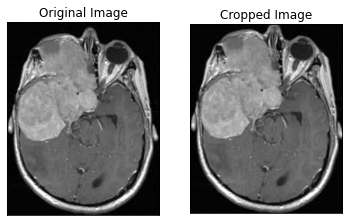

In [ ]:
ex_img = cv2.imread(image_dir+'yes/Y106.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

**Moving augmented images in the directories**

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 224, 224, 3)
y shape is: (2064, 1)


In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

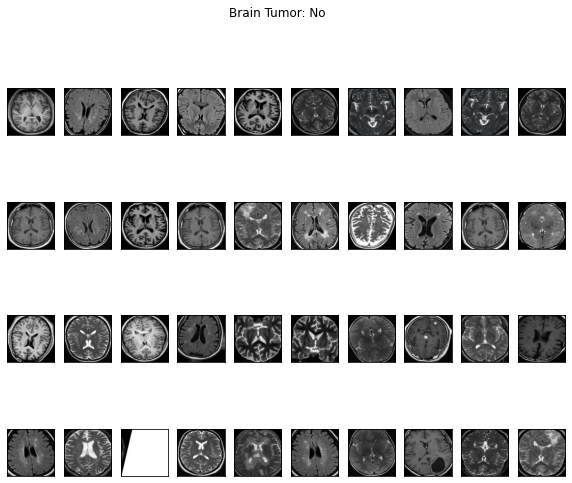

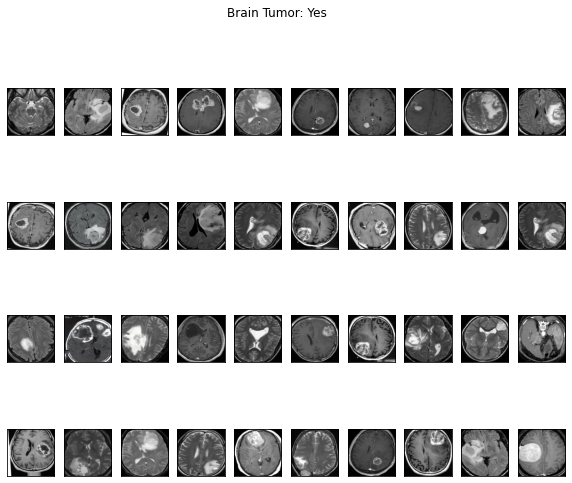

In [ ]:
plot_sample_images(X, y)

**Data splitting**

When developing a deep learning-based method, using a rigorous evaluation process is essential to avoid overfitting to training data or the generation of fake information. In order to evaluate the performance of the network, it is generally recommended to split data into training, valid, and test sets. The training set data are used to determine the network parameters. In most cases, the network shows good performance for the training set after an iterative learning process with the proper adjustment of the network structure and its hyperparameters, due to its very high capacity. Therefore, the separate validation set is required to predict the general performance of the network. The data in the validation set should not be fed into the network because the model should have the ability to apply external data not included in the training process.

In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.1)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1857
number of validation examples = 104
number of test examples = 103


**Creating the Ensemble Model**

Our first task would be to create all the individual models. I will be creating three different models using MobileNetV2, InceptionV3, and Xception. Creating a model using a pre-trained network is very easy in Tensorflow. We need to load the weights, decide whether to freeze or unfreeze the loaded weights, and finally add Dense layers to make the output how we want. The basic structure I will be using for my models.

In [ ]:
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

**Compiling and training the model**

In [ ]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')(global_average_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics='accuracy')
    return model

In [ ]:
batch_size = 32
epochs = 50
def fit_model(model):
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_data=(X_test, y_test)
                        )
    return history

In [ ]:
IMG_SHAPE = (224, 224, 3)
base_model1 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model3 = tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)
history1 = fit_model(model1)
model1.save('models/model1.h5')
history2 = fit_model(model2)
model2.save('models/model2.h5')
history3 = fit_model(model3)
model3.save('models/model3.h5')

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/50
59/59 [==============================] - 57s 388ms/step - loss: 0.3656 - accuracy: 0.8489 - val_loss: 2.2004 - val_accuracy: 0.4854
Epoch 2/50
59/59 [==============================] - 21s 354ms/step - loss: 0.0302 - accuracy: 0.9957 - val_loss: 2.6120 - val_accuracy: 0.4854
Epoch 3/50
59/59 [==============================] - 21s 354ms/step - loss: 0.0110 - accuracy: 0.9979 - val_loss: 2.5223 - val_accuracy: 0.5243
Epoch 4/50
59/59 [==============================] - 21s 353ms/step - loss: 0.0079 - accuracy: 0.9994 - val_loss: 2.2471 - val_accuracy: 0.6408
Epoch 5/50
59/59 [==============================] - 21s 357ms/step - loss: 0.0117 - accuracy: 0.9982 - val_loss: 1.8835 - val_accuracy: 0.6990
Epoch 6/50
59/59 [==============================] - 21s 354ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 1.8483 - val_accuracy: 0.6990
Epoch 7/50
59/59 [==============================] - 21s 356ms/step - loss: 0.

**Performance visualization**

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

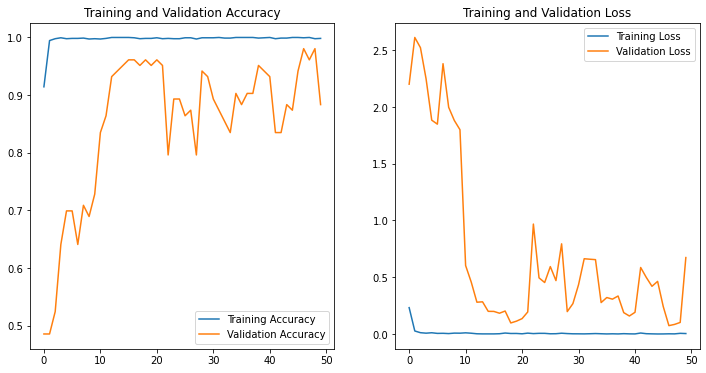

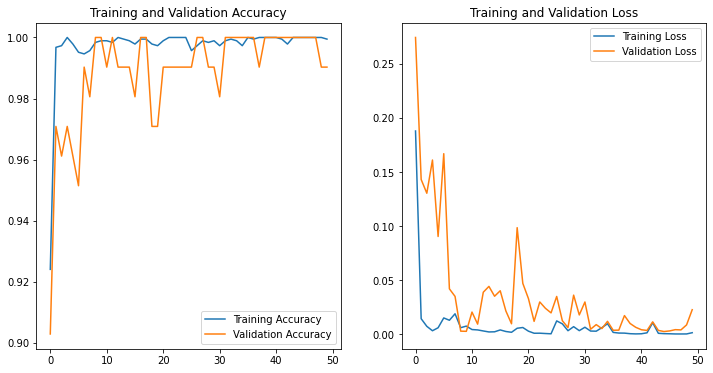

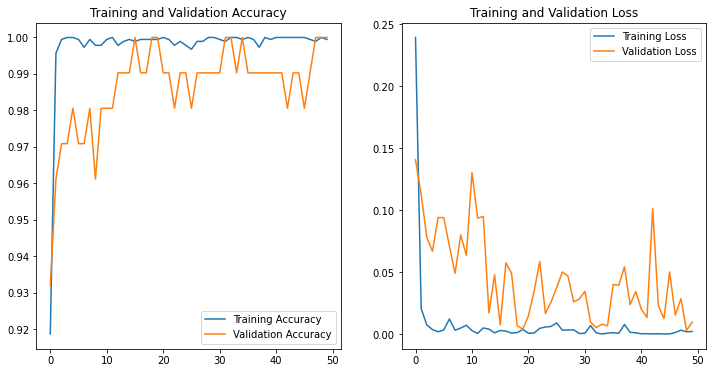

In [ ]:
plot_history(history1)
plot_history(history2)
plot_history(history3)

The results are not at all bad but we will still improve them.

**Load the Model and Freeze its Layers**

Our next step is to load the models we have just created above and freeze their layers so that their weights are not altered when we fit our ensemble model on them.

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['model1.h5', 'model2.h5', 'model3.h5']
    for model_name in model_names:
        filename = os.path.join('models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

**Concatenate their outputs and add Dense Layers**

Take the outputs of all the models and put them in a concatenation layer. Then add a Dense layer with some units followed by a Dense layer with a single output and an activation equal to “sigmoid” as our task is a binary classification. This can be thought of as an ANN where the predictions of all the models are taken as inputs and an output is provided.

**Compile and Train the Ensemble Model**

I used the classic ‘Adam’ optimizer with a little high learning rate of 10x-3 to compile the model.

In [ ]:
def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
          layer.trainable = False
          ensemble_visible = [model.input for model in models]
          ensemble_outputs = [model.output for model in models]
          merge = tf.keras.layers.concatenate(ensemble_outputs)
          merge = tf.keras.layers.Dense(10, activation='relu')(merge)
          output = tf.keras.layers.Dense(1, activation='sigmoid')(merge)
          model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
          model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
          
          return model

In [ ]:
models = load_all_models()
model = ensemble_model(models)

loaded: models/model1.h5
loaded: models/model2.h5
loaded: models/model3.h5


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'Ensemble-model.png', show_shapes=True)

**Training the ensemble model**

We cannot train the ensemble model normally by just passing the dataset like how we trained our individual models. Inputs are required at three places while only one output is generated. So we will need to configure our X values like that.

In [ ]:
X = [X_train for _ in range(len(model.input))]
X_1 = [X_test for _ in range(len(model.input))]

In [ ]:
epochs = 50
history = model.fit(X, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_1, y_test),
                    )

Epoch 1/50
59/59 [==============================] - 153s 2s/step - loss: 0.7083 - accuracy: 0.6063 - val_loss: 0.7066 - val_accuracy: 0.5243
Epoch 2/50
59/59 [==============================] - 129s 2s/step - loss: 0.6166 - accuracy: 0.8570 - val_loss: 0.7293 - val_accuracy: 0.4466
Epoch 3/50
59/59 [==============================] - 129s 2s/step - loss: 0.5701 - accuracy: 0.8828 - val_loss: 0.7074 - val_accuracy: 0.4466
Epoch 4/50
59/59 [==============================] - 130s 2s/step - loss: 0.4964 - accuracy: 0.8821 - val_loss: 0.7795 - val_accuracy: 0.4660
Epoch 5/50
59/59 [==============================] - 129s 2s/step - loss: 0.5009 - accuracy: 0.8401 - val_loss: 0.7307 - val_accuracy: 0.4272
Epoch 6/50
59/59 [==============================] - 130s 2s/step - loss: 0.4258 - accuracy: 0.8727 - val_loss: 0.6890 - val_accuracy: 0.4563
Epoch 7/50
59/59 [==============================] - 129s 2s/step - loss: 0.3378 - accuracy: 0.9469 - val_loss: 1.4045 - val_accuracy: 0.4466
Epoch 8/50
59

**Performance visualization**

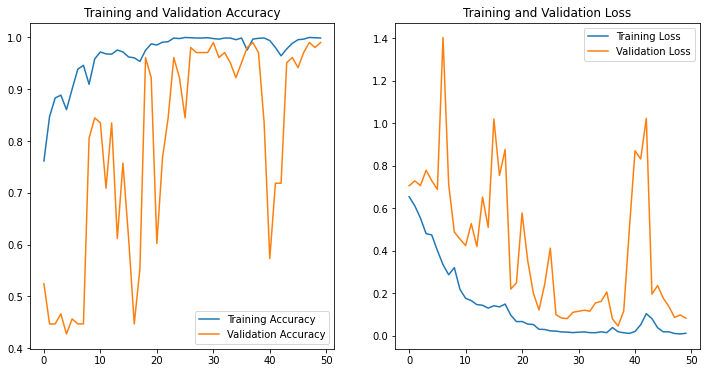

In [ ]:
plot_history(history)

In [ ]:
print('MobileNetV2 acc:', history1.history['val_accuracy'][-1])
print('InceptionV3 acc:', history2.history['val_accuracy'][-1])
print('Xception acc:', history3.history['val_accuracy'][-1])

MobileNetV2 acc: 0.8834951519966125
InceptionV3 acc: 0.9902912378311157
Xception acc: 1.0


In [ ]:
print('Ensemble acc:', history.history['val_accuracy'][-1])

Ensemble acc: 0.9902912378311157


We got an excellent accuracy for the ensemble model.

**Classification Report**

We evaluate Pecision, Recall, F1score, and Support for the ensemble model

In [ ]:
y_pred= model.predict(X_1)
y_pred = np.argmax(y_pred,axis=1)
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)
y_test_new = np.argmax(y_test,axis=1)

[0] [103]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
clf_report = classification_report(y_test_new,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



**Model Performance**

In [ ]:
import random

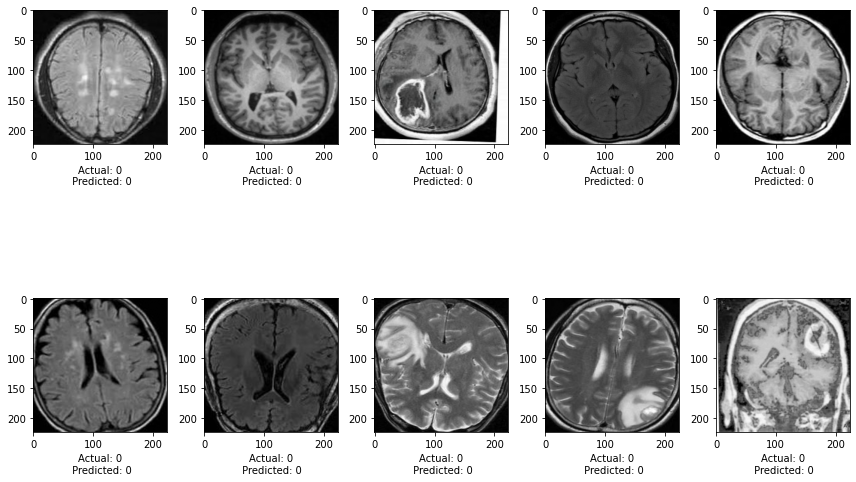

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(X_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(X_test [sample_idx])
    plt.xlabel(f"Actual: {y_test_new[sample_idx]}\n Predicted: {y_pred[sample_idx]}")
    
plt.tight_layout()
plt.show()